In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
# pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

# Check version
print('torch version: ', torch.__version__)

C:\ProgramData\Anaconda3\envs\spare\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\spare\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


torch version:  1.10.1


In [2]:
data_dir = './data'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



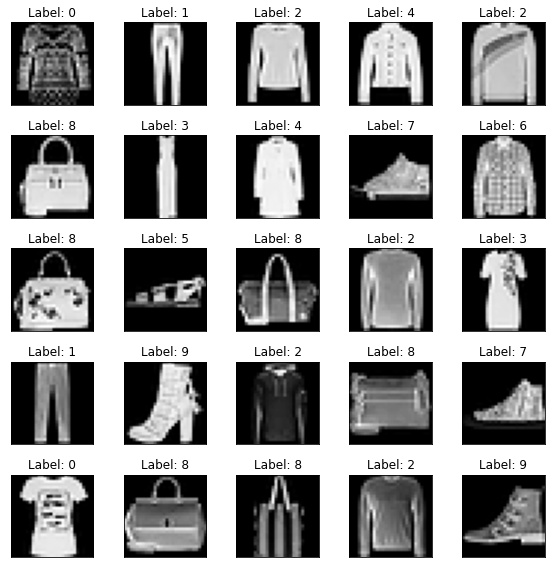

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m = len(train_dataset)

# random_split randomly split a dataset into non-overlapping new datasets of given lengths
# train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size = 256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


In [7]:
from torch.nn.parameter import Parameter

class channel_attention(nn.Module):    
    def __init__(self, channel, reduction = 4):
        super(channel_attention, self).__init__()
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)                    # Global Average Pooling (GAP)
        self.fc = nn.Sequential(                                   #
            nn.Linear(channel, channel // reduction, bias=False),  # fc1
            nn.ReLU(inplace=True),                                 # ReLU
            nn.Linear(channel // reduction, channel, bias=False),  # fc2
            nn.Sigmoid()                                           # Sigmoid
        )
        
    def forward(self, x): 
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        
        return x * y.expand_as(x)                                  # Fout = CA(Fin)

class spatial_attention(nn.Module):   
    def __init__(self, channel, k_size=3):
        super(spatial_attention, self).__init__()
        self.conv = nn.Conv2d(channel, 1, kernel_size=k_size, padding='same', bias=False)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        y = self.conv(x)
        y = self.sigmoid(y)
    
        return x * y.expand_as(x)
    
class parallel_add_attention(nn.Module):   
    def __init__(self, channel, k_size=3):
        super(parallel_add_attention, self).__init__()
        self.CA = channel_attention(channel)
        self.SA = spatial_attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
#         y = y1 + y2
        
        return y1 + y2
#         return x * y.expand_as(x)

class parallel_mul_attention(nn.Module):   
    def __init__(self, channel, k_size=3):
        super(parallel_mul_attention, self).__init__()
        self.CA = channel_attention(channel)
        self.SA = spatial_attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
        
        return torch.mul(y1,y2)
    
def autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block

def channel_autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        channel_attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block

def spatial_autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        spatial_attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block

def serial_CASA_autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        channel_attention(output_dim),
        spatial_attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block

def serial_SACA_autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        spatial_attention(output_dim),
        channel_attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block

def parallel_add_autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        parallel_add_attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block

def parallel_mul_autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        parallel_mul_attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = autoencoder_block(1, 16) 
        self.auto2 = autoencoder_block(16, 32)
        self.auto3 = autoencoder_block(32, 64)
        self.auto4 = autoencoder_block(64, 64)
        self.auto5 = autoencoder_block(64, 32)
        self.auto6 = autoencoder_block(32, 16)
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (32, 7, 7)
        x = self.upsample(x)                     # (32, 7, 7) -> (32, 14, 14)
        x = self.auto5(x)                        # (32, 14, 14) -> (16, 14, 14)
        x = self.upsample(x)                     # (16, 14, 14) -> (16, 28, 28)
        x = self.auto6(x)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [9]:
class Channel_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = channel_autoencoder_block(1, 16) 
        self.auto2 = channel_autoencoder_block(16, 32)
        self.auto3 = channel_autoencoder_block(32, 64)
        self.auto4 = channel_autoencoder_block(64, 64)
        self.auto5 = channel_autoencoder_block(64, 32)
        self.auto6 = channel_autoencoder_block(32, 16)
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (32, 7, 7)
        x = self.upsample(x)                     # (32, 7, 7) -> (32, 14, 14)
        x = self.auto5(x)                        # (32, 14, 14) -> (16, 14, 14)
        x = self.upsample(x)                     # (16, 14, 14) -> (16, 28, 28)
        x = self.auto6(x)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [10]:
class Spatial_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = spatial_autoencoder_block(1, 16) 
        self.auto2 = spatial_autoencoder_block(16, 32)
        self.auto3 = spatial_autoencoder_block(32, 64)
        self.auto4 = spatial_autoencoder_block(64, 64)
        self.auto5 = spatial_autoencoder_block(64, 32)
        self.auto6 = spatial_autoencoder_block(32, 16)
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (32, 7, 7)
        x = self.upsample(x)                     # (32, 7, 7) -> (32, 14, 14)
        x = self.auto5(x)                        # (32, 14, 14) -> (16, 14, 14)
        x = self.upsample(x)                     # (16, 14, 14) -> (16, 28, 28)
        x = self.auto6(x)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [11]:
class Serial_CASA_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = serial_CASA_autoencoder_block(1, 16) 
        self.auto2 = serial_CASA_autoencoder_block(16, 32)
        self.auto3 = serial_CASA_autoencoder_block(32, 64)
        self.auto4 = serial_CASA_autoencoder_block(64, 64)
        self.auto5 = serial_CASA_autoencoder_block(64, 32)
        self.auto6 = serial_CASA_autoencoder_block(32, 16)
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (32, 7, 7)
        x = self.upsample(x)                     # (32, 7, 7) -> (32, 14, 14)
        x = self.auto5(x)                        # (32, 14, 14) -> (16, 14, 14)
        x = self.upsample(x)                     # (16, 14, 14) -> (16, 28, 28)
        x = self.auto6(x)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [12]:
class Serial_SACA_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = serial_SACA_autoencoder_block(1, 16) 
        self.auto2 = serial_SACA_autoencoder_block(16, 32)
        self.auto3 = serial_SACA_autoencoder_block(32, 64)
        self.auto4 = serial_SACA_autoencoder_block(64, 64)
        self.auto5 = serial_SACA_autoencoder_block(64, 32)
        self.auto6 = serial_SACA_autoencoder_block(32, 16)
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (32, 7, 7)
        x = self.upsample(x)                     # (32, 7, 7) -> (32, 14, 14)
        x = self.auto5(x)                        # (32, 14, 14) -> (16, 14, 14)
        x = self.upsample(x)                     # (16, 14, 14) -> (16, 28, 28)
        x = self.auto6(x)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [13]:
class Parallel_Add_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = parallel_add_autoencoder_block(1, 16) 
        self.auto2 = parallel_add_autoencoder_block(16, 32)
        self.auto3 = parallel_add_autoencoder_block(32, 64)
        self.auto4 = parallel_add_autoencoder_block(64, 64)
        self.auto5 = parallel_add_autoencoder_block(64, 32)
        self.auto6 = parallel_add_autoencoder_block(32, 16)
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (32, 7, 7)
        x = self.upsample(x)                     # (32, 7, 7) -> (32, 14, 14)
        x = self.auto5(x)                        # (32, 14, 14) -> (16, 14, 14)
        x = self.upsample(x)                     # (16, 14, 14) -> (16, 28, 28)
        x = self.auto6(x)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [14]:
class Parallel_Mul_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = parallel_mul_autoencoder_block(1, 16) 
        self.auto2 = parallel_mul_autoencoder_block(16, 32)
        self.auto3 = parallel_mul_autoencoder_block(32, 64)
        self.auto4 = parallel_mul_autoencoder_block(64, 64)
        self.auto5 = parallel_mul_autoencoder_block(64, 32)
        self.auto6 = parallel_mul_autoencoder_block(32, 16)
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (32, 7, 7)
        x = self.upsample(x)                     # (32, 7, 7) -> (32, 14, 14)
        x = self.auto5(x)                        # (32, 14, 14) -> (16, 14, 14)
        x = self.upsample(x)                     # (16, 14, 14) -> (16, 28, 28)
        x = self.auto6(x)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [15]:
### Set the random seed for reproducible results
torch.manual_seed(0)

model1 = AutoEncoder()
model2 = Channel_AutoEncoder()
model3 = Spatial_AutoEncoder()
model4 = Serial_CASA_AutoEncoder()
model5 = Serial_SACA_AutoEncoder()
model6 = Parallel_Add_AutoEncoder()
model7 = Parallel_Mul_AutoEncoder()

In [16]:
import torchsummary
torchsummary.summary(model1, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

C:\ProgramData\Anaconda3\envs\spare\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [17]:
torchsummary.summary(model2, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
 AdaptiveAvgPool2d-2             [-1, 16, 1, 1]               0
            Linear-3                    [-1, 4]              64
              ReLU-4                    [-1, 4]               0
            Linear-5                   [-1, 16]              64
           Sigmoid-6                   [-1, 16]               0
 channel_attention-7           [-1, 16, 28, 28]               0
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           4,640
AdaptiveAvgPool2d-12             [-1, 32, 1, 1]               0
           Linear-13                    [-1, 8]             256
             ReLU-14                   

In [18]:
torchsummary.summary(model3, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2            [-1, 1, 28, 28]             144
           Sigmoid-3            [-1, 1, 28, 28]               0
 spatial_attention-4           [-1, 16, 28, 28]               0
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           4,640
            Conv2d-9            [-1, 1, 14, 14]             288
          Sigmoid-10            [-1, 1, 14, 14]               0
spatial_attention-11           [-1, 32, 14, 14]               0
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
        MaxPool2d-14             [-1, 3

In [19]:
torchsummary.summary(model4, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
 AdaptiveAvgPool2d-2             [-1, 16, 1, 1]               0
            Linear-3                    [-1, 4]              64
              ReLU-4                    [-1, 4]               0
            Linear-5                   [-1, 16]              64
           Sigmoid-6                   [-1, 16]               0
 channel_attention-7           [-1, 16, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]             144
           Sigmoid-9            [-1, 1, 28, 28]               0
spatial_attention-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 32,

In [20]:
torchsummary.summary(model5, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2            [-1, 1, 28, 28]             144
           Sigmoid-3            [-1, 1, 28, 28]               0
 spatial_attention-4           [-1, 16, 28, 28]               0
 AdaptiveAvgPool2d-5             [-1, 16, 1, 1]               0
            Linear-6                    [-1, 4]              64
              ReLU-7                    [-1, 4]               0
            Linear-8                   [-1, 16]              64
           Sigmoid-9                   [-1, 16]               0
channel_attention-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 32,

In [21]:
torchsummary.summary(model6, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
 AdaptiveAvgPool2d-2             [-1, 16, 1, 1]               0
            Linear-3                    [-1, 4]              64
              ReLU-4                    [-1, 4]               0
            Linear-5                   [-1, 16]              64
           Sigmoid-6                   [-1, 16]               0
 channel_attention-7           [-1, 16, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]             144
           Sigmoid-9            [-1, 1, 28, 28]               0
spatial_attention-10           [-1, 16, 28, 28]               0
parallel_add_attention-11           [-1, 16, 28, 28]               0
      BatchNorm2d-12           [-1, 16, 28, 28]              32
             ReLU-13           [-1, 16, 28, 28]               0
        MaxPool2d-14           [-1

In [22]:
torchsummary.summary(model7, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
 AdaptiveAvgPool2d-2             [-1, 16, 1, 1]               0
            Linear-3                    [-1, 4]              64
              ReLU-4                    [-1, 4]               0
            Linear-5                   [-1, 16]              64
           Sigmoid-6                   [-1, 16]               0
 channel_attention-7           [-1, 16, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]             144
           Sigmoid-9            [-1, 1, 28, 28]               0
spatial_attention-10           [-1, 16, 28, 28]               0
parallel_mul_attention-11           [-1, 16, 28, 28]               0
      BatchNorm2d-12           [-1, 16, 28, 28]              32
             ReLU-13           [-1, 16, 28, 28]               0
        MaxPool2d-14           [-1

In [23]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# AE to the image
img_ae1 = model1(img)
img_ae2 = model2(img)
img_ae3 = model3(img)
img_ae4 = model4(img)
img_ae5 = model5(img)
img_ae6 = model6(img)
img_ae7 = model7(img)


print('AE image shape:', img_ae1.shape, img_ae2.shape, img_ae3.shape)

Original image shape: torch.Size([1, 1, 28, 28])
AE image shape: torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


In [24]:
### Define the loss function
loss_fn1 = torch.nn.MSELoss()
loss_fn2 = torch.nn.MSELoss()
loss_fn3 = torch.nn.MSELoss()
loss_fn4 = torch.nn.MSELoss()
loss_fn5 = torch.nn.MSELoss()
loss_fn6 = torch.nn.MSELoss()
loss_fn7 = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.001
#lr = 0.0008 # Learning rate

optim1 = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-05)
optim2 = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=1e-05)
optim3 = torch.optim.Adam(model3.parameters(), lr=lr, weight_decay=1e-05)
optim4 = torch.optim.Adam(model4.parameters(), lr=lr, weight_decay=1e-05)
optim5 = torch.optim.Adam(model5.parameters(), lr=lr, weight_decay=1e-05)
optim6 = torch.optim.Adam(model6.parameters(), lr=lr, weight_decay=1e-05)
optim7 = torch.optim.Adam(model7.parameters(), lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
model1 = model1.to(device)
model2 = model2.to(device)
model3 = model3.to(device)
model4 = model4.to(device)
model5 = model5.to(device)
model6 = model6.to(device)
model7 = model7.to(device)

Selected device: cuda


In [25]:
### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Decode data
        decoded_data = model(image_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [26]:
### Testing function
def test_epoch(model, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Decode data
            decoded_data = model(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [27]:
def plot_ae_outputs(model, n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img = model(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

In [28]:
num_epochs = 20
history1 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model1, device, train_loader, loss_fn1, optim1)
    val_loss = test_epoch(model1, device, valid_loader, loss_fn1)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history1['train_loss'].append(train_loss)
    history1['val_loss'].append(val_loss)


 EPOCH 1/20 	 train loss 0.020 	 val loss 0.010

 EPOCH 2/20 	 train loss 0.008 	 val loss 0.007

 EPOCH 3/20 	 train loss 0.007 	 val loss 0.006

 EPOCH 4/20 	 train loss 0.006 	 val loss 0.006

 EPOCH 5/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 6/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 7/20 	 train loss 0.004 	 val loss 0.005

 EPOCH 8/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 9/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 10/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 11/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [29]:
num_epochs = 20
history2 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model2, device, train_loader, loss_fn2, optim2)
    val_loss = test_epoch(model2, device, valid_loader, loss_fn2)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history2['train_loss'].append(train_loss)
    history2['val_loss'].append(val_loss)


 EPOCH 1/20 	 train loss 0.024 	 val loss 0.010

 EPOCH 2/20 	 train loss 0.009 	 val loss 0.007

 EPOCH 3/20 	 train loss 0.007 	 val loss 0.006

 EPOCH 4/20 	 train loss 0.006 	 val loss 0.006

 EPOCH 5/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 6/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 7/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 9/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 10/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 11/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [30]:
num_epochs = 20
history3 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model3, device, train_loader, loss_fn3, optim3)
    val_loss = test_epoch(model3, device, valid_loader, loss_fn3)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history3['train_loss'].append(train_loss)
    history3['val_loss'].append(val_loss)


 EPOCH 1/20 	 train loss 0.018 	 val loss 0.009

 EPOCH 2/20 	 train loss 0.008 	 val loss 0.007

 EPOCH 3/20 	 train loss 0.007 	 val loss 0.006

 EPOCH 4/20 	 train loss 0.006 	 val loss 0.007

 EPOCH 5/20 	 train loss 0.005 	 val loss 0.006

 EPOCH 6/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 7/20 	 train loss 0.005 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.004 	 val loss 0.005

 EPOCH 9/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 10/20 	 train loss 0.004 	 val loss 0.005

 EPOCH 11/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 12/20 	 train loss 0.004 	 val loss 0.003

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [31]:
num_epochs = 20
history4 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model4, device, train_loader, loss_fn4, optim4)
    val_loss = test_epoch(model4, device, valid_loader, loss_fn4)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history4['train_loss'].append(train_loss)
    history4['val_loss'].append(val_loss)


 EPOCH 1/20 	 train loss 0.020 	 val loss 0.010

 EPOCH 2/20 	 train loss 0.008 	 val loss 0.007

 EPOCH 3/20 	 train loss 0.007 	 val loss 0.007

 EPOCH 4/20 	 train loss 0.006 	 val loss 0.006

 EPOCH 5/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 6/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 7/20 	 train loss 0.005 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.004 	 val loss 0.005

 EPOCH 9/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 10/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 11/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 12/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 13/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [32]:
num_epochs = 20
history5 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model5, device, train_loader, loss_fn5, optim5)
    val_loss = test_epoch(model5, device, valid_loader, loss_fn5)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history5['train_loss'].append(train_loss)
    history5['val_loss'].append(val_loss)


 EPOCH 1/20 	 train loss 0.018 	 val loss 0.009

 EPOCH 2/20 	 train loss 0.008 	 val loss 0.008

 EPOCH 3/20 	 train loss 0.006 	 val loss 0.006

 EPOCH 4/20 	 train loss 0.006 	 val loss 0.005

 EPOCH 5/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 6/20 	 train loss 0.005 	 val loss 0.004

 EPOCH 7/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 9/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 10/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 11/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.005

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.005

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [33]:
num_epochs = 20
history6 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model6, device, train_loader, loss_fn6, optim6)
    val_loss = test_epoch(model6, device, valid_loader, loss_fn6)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history6['train_loss'].append(train_loss)
    history6['val_loss'].append(val_loss)


 EPOCH 1/20 	 train loss 0.018 	 val loss 0.009

 EPOCH 2/20 	 train loss 0.008 	 val loss 0.007

 EPOCH 3/20 	 train loss 0.006 	 val loss 0.006

 EPOCH 4/20 	 train loss 0.006 	 val loss 0.005

 EPOCH 5/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 6/20 	 train loss 0.005 	 val loss 0.004

 EPOCH 7/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 9/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 10/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 11/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [34]:
num_epochs = 20
history7 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model7, device, train_loader, loss_fn7, optim7)
    val_loss = test_epoch(model7, device, valid_loader, loss_fn7)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history7['train_loss'].append(train_loss)
    history7['val_loss'].append(val_loss)


 EPOCH 1/20 	 train loss 0.132 	 val loss 0.124

 EPOCH 2/20 	 train loss 0.049 	 val loss 0.036

 EPOCH 3/20 	 train loss 0.026 	 val loss 0.021

 EPOCH 4/20 	 train loss 0.019 	 val loss 0.017

 EPOCH 5/20 	 train loss 0.016 	 val loss 0.014

 EPOCH 6/20 	 train loss 0.014 	 val loss 0.013

 EPOCH 7/20 	 train loss 0.013 	 val loss 0.012

 EPOCH 8/20 	 train loss 0.012 	 val loss 0.011

 EPOCH 9/20 	 train loss 0.011 	 val loss 0.010

 EPOCH 10/20 	 train loss 0.010 	 val loss 0.009

 EPOCH 11/20 	 train loss 0.009 	 val loss 0.008

 EPOCH 12/20 	 train loss 0.010 	 val loss 0.010

 EPOCH 13/20 	 train loss 0.008 	 val loss 0.008

 EPOCH 14/20 	 train loss 0.008 	 val loss 0.008

 EPOCH 15/20 	 train loss 0.008 	 val loss 0.007

 EPOCH 16/20 	 train loss 0.007 	 val loss 0.007

 EPOCH 17/20 	 train loss 0.007 	 val loss 0.006

 EPOCH 18/20 	 train loss 0.007 	 val loss 0.006

 EPOCH 19/20 	 train loss 0.008 	 val loss 0.007

 EPOCH 20/20 	 train loss 0.007 	 val loss 0.006


<Figure size 1152x720 with 0 Axes>

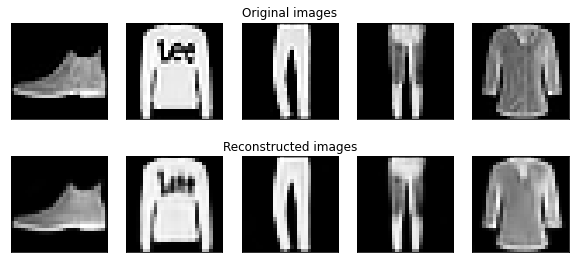

In [35]:
# Normal AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model1, n=5)

<Figure size 1152x720 with 0 Axes>

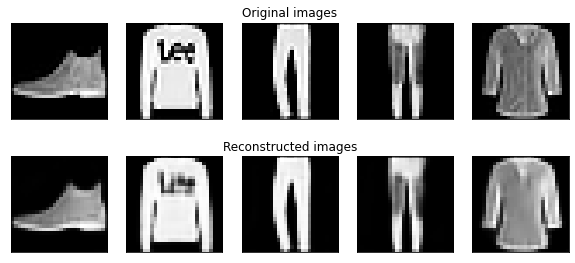

In [36]:
# Channel AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model2, n=5)

<Figure size 1152x720 with 0 Axes>

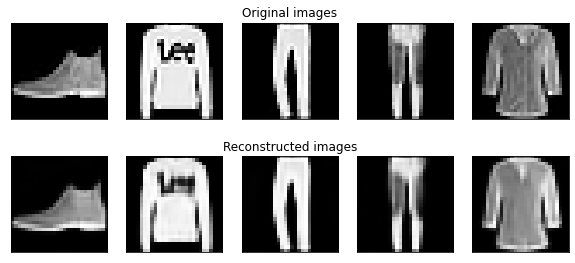

In [37]:
# Spatial AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model3, n=5)

<Figure size 1152x720 with 0 Axes>

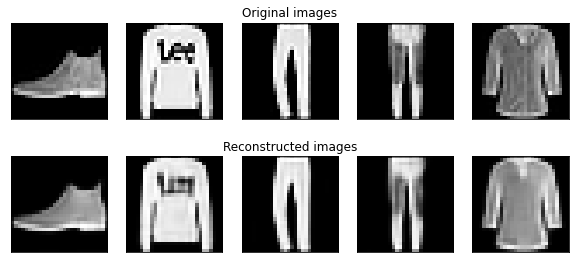

In [38]:
# Serial CASA AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model4, n=5)

<Figure size 1152x720 with 0 Axes>

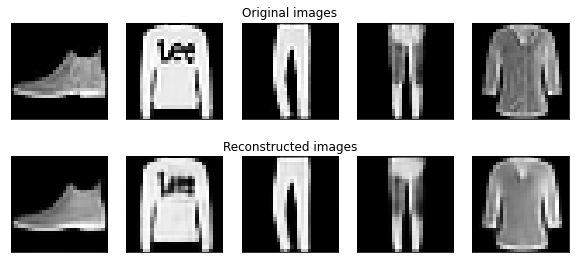

In [39]:
# Serial SACA AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model5, n=5)

<Figure size 1152x720 with 0 Axes>

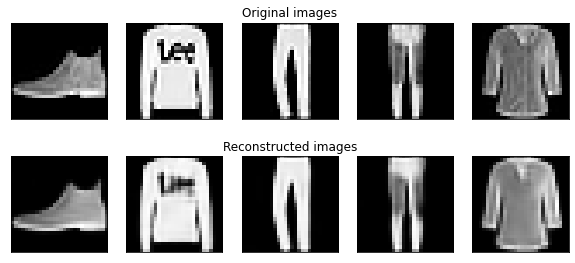

In [40]:
# Parallel add AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model6, n=5)

<Figure size 1152x720 with 0 Axes>

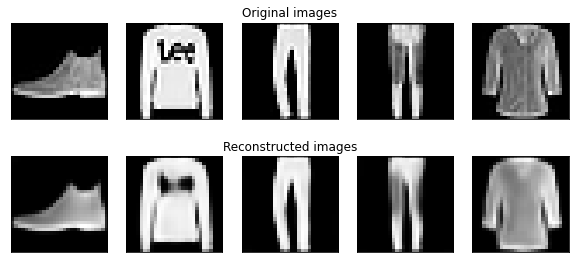

In [41]:
# Parallel mul AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model7, n=5)

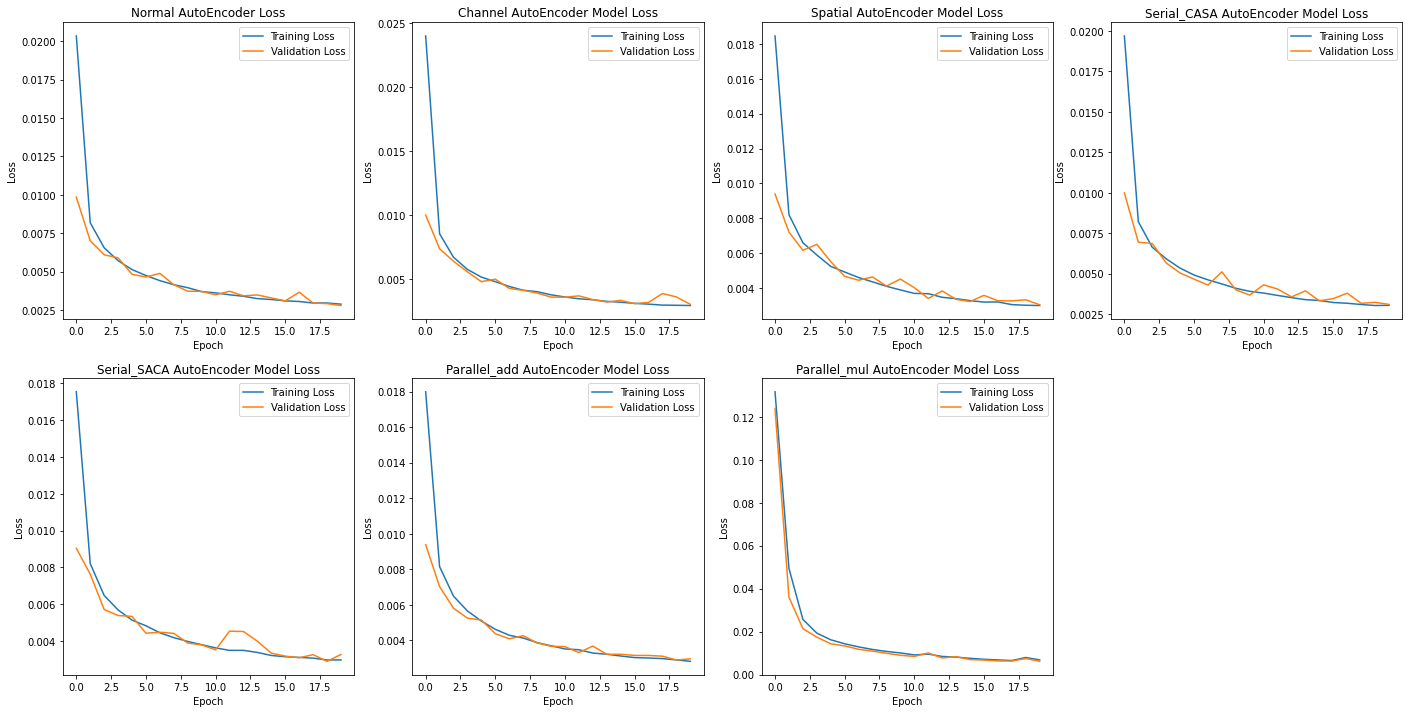

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(history1['train_loss'])
plt.plot(history1['val_loss'])
plt.title('Normal AutoEncoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(history2['train_loss'])
plt.plot(history2['val_loss'])
plt.title('Channel AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(history3['train_loss'])
plt.plot(history3['val_loss'])
plt.title('Spatial AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(history4['train_loss'])
plt.plot(history4['val_loss'])
plt.title('Serial_CASA AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(history5['train_loss'])
plt.plot(history5['val_loss'])
plt.title('Serial_SACA AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(history6['train_loss'])
plt.plot(history6['val_loss'])
plt.title('Parallel_add AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(history7['train_loss'])
plt.plot(history7['val_loss'])
plt.title('Parallel_mul AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.savefig('result_autoencoder.jpg')
plt.show()
